# Generate input files for MOM6
Required components
* Horizontal grid
    + determined externally using FRE-NCtools, loaded here to provide geometry
* Vertical grid
    + either calculated here, or externally
* Sponge region
    + calculated here
* Intial conditions for tracers
    + T, S and biogeochemical tracers, calculated here
* Wind and buoyancy forcing
    + calculated here
* Topography
    + calculated here
* Inital velocity perturbation
    + used to nudge the model
    + calculated here


In [173]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import initialization_functions as infs

In [151]:
# Directory into which to save files
rootdir = '/work/gam/MOM6/inputs/'
config = 'channel'
simulation = '4th-deg'

In [3]:
# Load the grid
gridpath = '/work/gam/MOM6/inputs/channel/ocean_geometry.nc'
hgrid = xr.open_dataset(gridpath)
hgrid_ones = xr.ones_like(hgrid['geolon'])

In [122]:
X,Y = infs.calc_XYmeters(hgrid,center_x = True)

In [168]:
# Vertical grid
nk = 50
max_depth = 4000
min_depth = 0
thkcello_topcell = 1
method = 'powerlaw'

vgrid = infs.calc_vgrid(nk=nk,max_depth=max_depth,min_depth=min_depth,thkcello_topcell=thkcello_topcell,method=method)
# Save
vgrid.to_netcdf(rootdir+config+'/'+simulation+'_vgrid'+'.nc')

In [192]:
# Temperature and salinity initial conditions
Tn = 10
Ts = 0
Sn = 35
Ss = 33

TS = xr.Dataset()
TS['SST'] = calc_distribution(coordinate = Y, function='linear', val_at_maxcoord = Tn, val_at_mincoord = Ts)
TS['SSS'] = calc_distribution(coordinate = Y, function='linear', val_at_maxcoord = Sn, val_at_mincoord = Ss)

# Extend temperature and salinity in the vertical
TS['T'] = infs.calc_distribution(coordinate=-vgrid.zt, function = 'exponential', val_at_maxcoord = TS['SST'], efolding = 800)
TS['S'] = infs.calc_distribution(coordinate=-vgrid.zt, function = 'linear', val_at_maxcoord = TS['SSS'], val_at_mincoord = SSS+1)

TS = TS.transpose('NK','lath','lonh')
TS.to_netcdf(rootdir+config+'/'+simulation+'_TS'+'.nc')

In [193]:
# Sponge region
sponge_width = [100E3,50E3]
idampval=[1/(720*86400),1/(360*86400)]

sponge = xr.Dataset()
sponge['idamp'] = infs.def_sponge_dampingtimescale_north(Y,sponge_width=sponge_width,idampval=idampval)
sponge['eta'] = infs.def_sponge_interfaceheight(vgrid,Y)

# Add temperature and salinity profile to sponge region
sponge['T'] = TS['T']
sponge['S'] = TS['S']

sponge = sponge.transpose('NKp1','NK','lath','lonh')
sponge.to_netcdf(rootdir+config+'/'+simulation+'_sponge'+'.nc')

In [178]:
# Wind forcing
taux_east = 0.15
taux_west = 0.05
Y0 = 500*1E3 # Boundary between ACC/ASF
Yb = 1200*1E3 # Meridional position of bump
Ys = 300*1E3 # Location of continental slope
Ws = 75*1E3 # Half-width of continental slope
Lc = 100*1E3 # Width of shelf cooling


wind = xr.Dataset()
wind['taux'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_squared',
                                 sponge_width_max = sponge_width[0],
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = taux_east, 
                                 max_south = taux_west)
wind['tauy'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)

# Save
wind = wind.transpose('lath','lonh')
wind.to_netcdf(rootdir+config+'/'+simulation+'_wind'+'.nc')

buoyancy = xr.Dataset()
buoyancy['LW'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['SW'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['sensible'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['latent'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['evap'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['froz_precip'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['froz_runoff'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['liq_precip'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['liq_runoff'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)

# Save
buoyancy = buoyancy.transpose('lath','lonh')
buoyancy.to_netcdf(rootdir+config+'/'+simulation+'_buoyancy'+'.nc')

In [167]:
# Intial velocity nudge
center = 0
width = 2E5

velocity = xr.Dataset()
u = infs.calc_distribution(coordinate=X*xr.ones_like(vgrid['zt']), function = 'gaussian', center = center, width = width)
velocity['u'] = infs.make_zeroinsponge(u,Y,sponge_width_max = sponge_width[0])
velocity['v'] = infs.calc_distribution(coordinate=X, function = 'uniform', uniform_value = 0.0)

# Save
velocity = velocity.transpose('NK','lath','lonh')
velocity.to_netcdf(rootdir+config+'/'+simulation+'_velocity'+'.nc')

In [179]:
def create_shelf(H, Hs, Y1, Ys, Ws):
    # H = max depth, Hs = shelf depth, Y1 = lat, Ys = shelf latitude, Ws = shelf width
    depth_shelf = 0.5*(H - Hs)*(1 - np.tanh((Y1 - Ys)/Ws))
    
    return depth_shelf

def create_2D_guassian_ridge(Hs, X1, Xs, Y1, Ys, Wx, Wy, theta):
    # Hs = ridge height, X1 = lon, Y1 = lat, Xs, Ys = shelf lan and lat, Wx, Wy = ridge length and width
    # ridge rotation
    
    a = np.cos(theta)**2/(2*Wx**2) + np.sin(theta)**2/(2*Wy**2);
    b = -np.sin(2*theta)/(4*Wx**2) + np.sin(2*theta)/(4*Wy**2);
    c = np.sin(theta)**2/(2*Wx**2) + np.cos(theta)**2/(2*Wy**2);

    Z = Hs*np.exp( - (a*(X1-Xs)**2 + 2*b*(X1-Xs)*(Y1-Ys) + c*(Y1-Ys)**2));
    
    return Z

def create_rectangular_bump(Hs, X1, Xs, Y1, Ys, Wx, Wy, dx, dy):
    # Hs = max depth X1 = lon, Y1 = lat, Xs, Ys = bump lan and lat, Wx, Wy = bump length and width
    # dx, dy = controls the rate of bump heigh decay
    x = (X1 - Xs)/Wx
    y = (Y1 - Ys)/Wy
    z = np.exp(-dx/(1 - x**2) - dy/(1 - y**2))
    
    condition = (np.abs(x) >= 1.) | (np.abs(y) >= 1.)
    z = z.where(~condition,0)
    
    z = z*Hs/np.max(z)
    
    return z

In [194]:
min_shelf_depth, shelf_lat, shelf_width = (500., Ys, Ws)
#min_shelf_depth, shelf_lat, shelf_width = (500., -48., 2.0)
d_shelf = create_shelf(max_depth, min_shelf_depth, Y, shelf_lat, shelf_width)

ridge_depth, ridge_lon, ridge_lat, ridge_width_x, ridge_width_y = (3000., -1000000., 2000000., 500000., 5000000.)
#ridge_depth, ridge_lon, ridge_lat, ridge_width_x, ridge_width_y = (3000., 20., -35., 5.0, 50.)
theta = -30.*np.pi/180
d_ridge = create_2D_guassian_ridge(ridge_depth, X, ridge_lon, Y, ridge_lat, ridge_width_x, ridge_width_y, theta)

bump_depth, bump_lon, bump_lat, bump_width_x, bump_width_y = (1., -1000000., 2000000., 1000000.0, 1000000.)
#bump_depth, bump_lon, bump_lat, bump_width_x, bump_width_y = (1., 20., -40., 20.0, 15.)
bump_decay_x, bump_decay_y = (1., 1.)
d_bump = create_rectangular_bump(bump_depth, X, bump_lon, Y, bump_lat, bump_width_x, bump_width_y, 
                                 bump_decay_x, bump_decay_y)

#height = np.maximum(d_shelf, d_ridge*d_bump) 
height = np.maximum(d_shelf, d_bump*3000.) 

topography = xr.Dataset()
topography['depth'] = -1*(-max_depth + height)

# Save
topography.transpose('lath','lonh')
topography.to_netcdf(rootdir+config+'/'+simulation+'_topography'+'.nc')

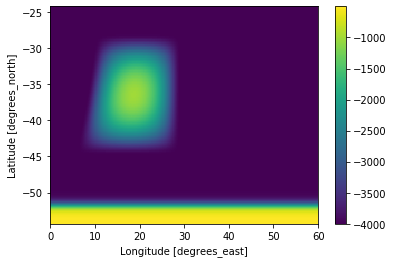

In [183]:
depth.plot()